Slide 1
<!--- ![](../reports/presentations/20231205/1.png) -->

# Pipeline

Slides 2-4
<!--- ![](../reports/presentations/20231205/2.png)
![](../reports/presentations/20231205/3.png)
![](../reports/presentations/20231205/4.png)--->

## Setup

### Imports

In [1]:
# External imports
import os
import sys
import spacy


# Get the current working directory (assuming the notebook is in the notebooks folder)
current_dir = os.getcwd()

# Add the parent directory (project root) to the Python path
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)

# Relative imports
from src.utils import ld_spcy_mdl
from src.preprocess import txt_to_df, rplc_and_rmv, chng_stpwrds, lmtz_and_rmv_stpwrds, split_to_chunks
from src.modelling import search_constraints_in_data 
from src.modelling import ConstraintSearcher as CS
from src.evaluation import cnstrnts_gs, sbert_smlarty, sbert_smlarty_cmpntns, evlt_prec_rec

/Users/leoh/Workspace/Anaconda/anaconda3/envs/nlp-rules/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Files

In [2]:
# Define variables to use as keys
aktg = "AktG"
cdm_01 = "CDM 01: A/R Mangroves"
cdm_02 = "CDM 02: A/R Non-wetlands"
cdm_03 = "CDM 03: Cable Cars"
cdm_04 = "CDM 04: Energy Efficiency"
cdm_05 = "CDM 05: Electriciy Generation"
coffee = "Coffee"
patg = "PatG"

# Define file paths
file_paths_input = {
    aktg: os.path.join('..', 'data', 'aktg', 'input_aktg.txt'),
    cdm_01: os.path.join('..', 'data', 'cdm', 'input_cdm_01.txt'),
    cdm_02: os.path.join('..', 'data', 'cdm', 'input_cdm_02.txt'),
    cdm_03: os.path.join('..', 'data', 'cdm', 'input_cdm_03.txt'),
    cdm_04: os.path.join('..', 'data', 'cdm', 'input_cdm_04.txt'),
    cdm_05: os.path.join('..', 'data', 'cdm', 'input_cdm_05.txt'),  
    coffee: os.path.join('..', 'data', 'coffee', 'input_coffee.txt'),
    patg: os.path.join('..', 'data', 'patg', 'input_patg.txt'),  
}

file_paths_output = {
    aktg: os.path.join('..', 'data', 'aktg', 'output_aktg.txt'),
    cdm_01: os.path.join('..', 'data', 'cdm', 'output_cdm_01.txt'),
    cdm_02: os.path.join('..', 'data', 'cdm', 'output_cdm_02.txt'),
    cdm_03: os.path.join('..', 'data', 'cdm', 'output_cdm_03.txt'),
    cdm_04: os.path.join('..', 'data', 'cdm', 'output_cdm_04.txt'),
    cdm_05: os.path.join('..', 'data', 'cdm', 'output_cdm_05.txt'),  
    coffee: os.path.join('..', 'data', 'coffee', 'output_coffee.txt'),
    patg: os.path.join('..', 'data', 'patg', 'output_patg.txt'),  
}

### Parameter

In [3]:
# spaCy model
model = 'en_core_web_lg'

# Define custom stop words
add_stpwrds = []
non_stpwrds = [
    "a",
    "above",
    "all",
    "amount",
    "and",
    "as",
    "at",
    "be",
    "before",
    "below",
    "between",
    "beyond",
    "both",
    "by",
    "can",
    "each",
    "either",
    "else",
    "even",
    "except",
    "for",
    "i",
    "if",
    "last",
    "least",
    "less",
    "may",
    "more",
    "most",
    "must",
    "name",
    "next",
    "no",
    "none",
    "not",
    "nothing",
    "of",
    "on",
    "only",
    "otherwise",
    "over",
    "or",
    "out",
    "per",
    "several",
    "should",
    "than",
    "then",
    "to",
    "under",
    "up",
    "what",
    "when",
    "with"
]


# This is needed because spaCy struggles with linebreak characters, but the information is needed for the enumeration (see also https://github.com/explosion/spaCy/issues/7735)
linebreak = " NEWLINE "

# Define character sequences to replace
replace = {"\n\n": "\n", 
           "\n \n": "\n",
           "\n \n\n": "\n",
           "\n\n \n": "\n",
           "\n": linebreak,
           "   ": " ",
           "  ": " "} 

# Define character sequences to remove
remove=["\t"]

# Patterns for different enumeration items types
enum_patterns = {
    'number_in_parentheses': r"\(\d+\)",
    'number_with_dot': r"\d+\.",
    'alphabetical_in_parentheses': r"\([a-z]\)",
    'roman_numeral_in_parentheses': r"\([ivxlcdm]+\)",
}

# Define equality matching parameters
equality_params = {
    "general": {
        "must": "==",
        "shall": "==",
        "should": "=="
    },
    "exceptions": {
        # aktg
        "be to set out": "==",
        "applicable under": "==",
        # cdm_01
        "apply to": "==",
        # cdm_02
        "applicable to": "==",
        # cdm_03
        "eligible under": "==",
        # cdm_05
        "category comprise": "==",
        "include category": "==",
        "be limit to": "==",
        # patg
        "be to be": "=="
    },
    "negation_operators": {
        "==": "!="
    },
    "negation_tokens": {"not", "no"},
    "window_size": (3, 2)
}

# Define inequality matching parameters
inequality_params = {
    "general": {
        "below": "<",
        "less than": "<",
        "low than": "<",
        "small than": "<",
        "as high as": "<=",
        "at most": "<=",
        "up to": "<=",
        "remain at": "<=",
        "above": ">",
        "beyond": ">",
        "exceed": ">",
        "great than": ">",
        "high than": ">",
        "more than": ">",
        "surpass": ">",
        "at least": ">="
    },
    "exceptions": {},
    "negation_operators": {
        "<": ">=",
        "<=": ">",
        ">": "<=",
        ">=": "<"
    },
    "negation_tokens": {"not", "no"},
    "window_size": (5, 0)
}

inequality_exception_patterns = {
    # coffee
    "reach_beyond": lambda: [{"LOWER": "reach"}] + CS.no_digit_or_period() + [{"LIKE_NUM": True}] + CS.no_digit_or_period() + [{"LOWER": "beyond"}],
    "low_allow": lambda: [{"LOWER": "low"}] + CS.no_digit_or_period() + [{"LOWER": "allow"}] + CS.no_digit_or_period() + [{"LIKE_NUM": True}],
    "between": lambda: [{"LOWER": "between"}, {"LIKE_NUM": True}] + CS.no_digit_or_period() + [{"LIKE_NUM": True}],
    "brackets": lambda: [{"TEXT": "["}, {"LIKE_NUM": True}, {"IS_DIGIT": False, "OP": "?"},{"IS_DIGIT": False, "OP": "?"},{"IS_DIGIT": False, "OP": "?"},{"LIKE_NUM": True},{"IS_DIGIT": False, "OP": "*"}, {"TEXT": "]"}],
    "parentheses": lambda: [{"TEXT": "("}, {"LIKE_NUM": True}, {"IS_DIGIT": False, "OP": "?"},{"IS_DIGIT": False, "OP": "?"},{"IS_DIGIT": False, "OP": "?"},{"LIKE_NUM": True},{"IS_DIGIT": False, "OP": "*"}, {"TEXT": ")"}]
}

equality_exception_patterns = {
    # aktg
    "may_only": lambda: [{"LOWER": "may"}] + CS.no_digit_or_period() + [{"LOWER": "only"}],
    # cdm_01
    "fall_in": lambda: [{"LOWER": "fall"}] + CS.no_digit_or_period() + [{"LOWER": "category"}],
    # cdm_04
    "none_may": lambda: [{"LOWER": "none"}] + CS.no_digit_or_period() + [{"LOWER": "may"}],
}

In [4]:
linebreak.strip()

'NEWLINE'

In [5]:
# Load the spaCy model
nlp = ld_spcy_mdl(model=model)

# Add and remove custom stop words globally to the spacy.util.get_lang_class('en')
stpwrds = chng_stpwrds(nlp, add=add_stpwrds,remove=non_stpwrds, remove_numbers=True,verbose=False)
# Uncomment this line to restore the default set of stpwrds
# stpwrds = chng_stpwrds(restore_default=True, verbose=True)

The model en_core_web_lg is already installed!
eight successfuly added to removal list!
eleven successfuly added to removal list!
fifteen successfuly added to removal list!
fifty successfuly added to removal list!
first successfuly added to removal list!
five successfuly added to removal list!
forty successfuly added to removal list!
four successfuly added to removal list!
hundred successfuly added to removal list!
nine successfuly added to removal list!
one successfuly added to removal list!
six successfuly added to removal list!
sixty successfuly added to removal list!
ten successfuly added to removal list!
third successfuly added to removal list!
three successfuly added to removal list!
twelve successfuly added to removal list!
twenty successfuly added to removal list!
two successfuly added to removal list!
Stop word [ a ] successfully removed!
Stop word [ above ] successfully removed!
Stop word [ all ] successfully removed!
Stop word [ amount ] successfully removed!
Stop word [ and

## Preprocessing

In [7]:
def optimized_preprocessing(nlp, file_path, replace, remove, linebreak):
    """
    An optimized function that combines reading a file, preprocessing the text,
    and splitting into sentences. It uses a single SpaCy model loaded outside.

    :param nlp: Pre-loaded SpaCy model.
    :param file_path: Path to the file.
    :param replace: Mapping of strings to replace.
    :param remove: List of strings to remove.
    :param linebreak: The character replacing a linebreak to split into chunks.
    :return: Dataframe with processed text.
    """
    df = txt_to_df(file_path)
    
    for index, row in df.iterrows():
        ## Preprocessing
        # Removing and replacing special characters
        processed_text = rplc_and_rmv(row['Raw'], replace, remove)
        # Splitting into chunks
        chunks = split_to_chunks(nlp, processed_text, enum_patterns, linebreak)
        df.at[index, 'Chunks'] = chunks
        # Check if chunks is not empty
        if chunks:
            # Lemmatizing and removing stop words
            results = [lmtz_and_rmv_stpwrds(nlp, chunk) for chunk in chunks]
            lemmatized_chunks, alignments, succeding_linebreaks = zip(*results)
        else:
            # Provide default values for empty chunks
            lemmatized_chunks, alignments, succeding_linebreaks = [], [], []
        df.at[index, 'Lemma'] = lemmatized_chunks
        df.at[index, 'Alignment'] = alignments
        df.at[index, 'Linebreak'] = succeding_linebreaks

    return df

# Process all files
data = {case: optimized_preprocessing(nlp, path, replace, remove, linebreak) for case, path in file_paths_input.items()}

In [8]:
test = data[cdm_02].iloc[2]

In [10]:
for c in test.Chunks:
    print("\nCHUNK\n")
    print(c)


CHUNK

This methodology is applicable under the following conditions: 
 (a) The land subject to the project activity does not fall in wetland category; 
 (b) Soil disturbance attributable to the project activity does not cover more than 10 per cent of area in each of the following types of land, when these lands are included within the project boundary: 
 (i) Land containing organic soils; 
 (ii) Land which, in the baseline, is subjected to land-use and management practices and receives inputs listed in appendices 2 and 3 to this methodology.

CHUNK

A project activity applying this methodology shall also comply with the applicability conditions of the tools contained within the methodology and applied by the project activity


In [13]:
for c in test.Linebreak:
    print("\nCHUNK\n")
    print(c)


CHUNK

[False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]

CHUNK

[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]


In [54]:
text = test.Processed[0]
text

'This methodology is applicable under the following conditions: \n (a) The land subject to the project activity does not fall in wetland category; \n (b) Soil disturbance attributable to the project activity does not cover more than 10 per cent of area in each of the following types of land, when these lands are included within the project boundary: \n (i) Land containing organic soils; \n (ii) Land which, in the baseline, is subjected to land-use and management practices and receives inputs listed in appendices 2 and 3 to this methodology.'

In [55]:
print(text)

This methodology is applicable under the following conditions: 
 (a) The land subject to the project activity does not fall in wetland category; 
 (b) Soil disturbance attributable to the project activity does not cover more than 10 per cent of area in each of the following types of land, when these lands are included within the project boundary: 
 (i) Land containing organic soils; 
 (ii) Land which, in the baseline, is subjected to land-use and management practices and receives inputs listed in appendices 2 and 3 to this methodology.


In [64]:
processed_text, alignment, suc_linebreaks = lmtz_and_rmv_stpwrds(nlp, text)
print(processed_text)
print(alignment)
print(suc_linebreaks)
# for (new, old), tok in zip(alignment.items(), doc):
#     print(text[old:old+len(tok.text)])
doc = nlp(processed_text)
for i in range(len(suc_linebreaks)):
    if suc_linebreaks[i]:
        print(doc[i-3:i+1])


methodology be applicable under follow condition : ( a ) land subject to project activity not fall wetland category ; ( b ) soil disturbance attributable to project activity not cover more than 10 per cent of area each of follow type of land , when land be include project boundary : ( i ) land contain organic soil ; ( ii ) Land , baseline , be subject to land - use and management practice and receive input list appendix 2 and 3 to methodology .
{0: 5, 12: 17, 15: 20, 26: 31, 32: 41, 39: 51, 49: 61, 51: 65, 53: 66, 55: 67, 57: 73, 62: 78, 70: 86, 73: 93, 81: 101, 90: 115, 94: 119, 99: 127, 107: 135, 116: 143, 118: 147, 120: 148, 122: 149, 124: 151, 129: 156, 141: 168, 154: 181, 157: 188, 165: 196, 174: 210, 178: 214, 184: 220, 189: 225, 194: 230, 197: 233, 201: 237, 206: 242, 209: 245, 214: 253, 219: 258, 222: 265, 229: 275, 234: 281, 237: 284, 242: 288, 244: 290, 249: 301, 254: 307, 257: 311, 265: 331, 273: 339, 282: 347, 284: 351, 286: 352, 288: 353, 290: 355, 295: 360, 303: 371, 311:

In [65]:
print(processed_text[257:273])
print(text[311:339])

include project 
included within the project 


## Modelling

### Constraint Search

In [10]:
constraints = search_constraints_in_data(nlp, data, equality_params, inequality_params, inequality_exception_patterns, equality_exception_patterns)

----------------------------------------
---------------------------------------- 

AKTG
----------------------------------------
---------------------------------------- 


###CHUNK###

establishment of by - law 
  ( 1 ) by - law must be establish by way of be record by a notary
  ID  Type    Match     Pattern    Exception    Negation    Predecessor    Successor
----  ------  --------  ---------  -----------  ----------  -------------  -------------
   1  EQ      (12, 13)  MUST       False        False       (0, 'START')   (2, 'FOLLOW')

###CHUNK###

authorised representative may act only if a power of attorney certify by a notary
  ID  Type    Match    Pattern    Exception    Negation    Predecessor    Successor
----  ------  -------  ---------  -----------  ----------  -------------  -------------
   2  EQ      (2, 5)   MAY_ONLY   True         False       (1, 'FOLLOW')  (3, 'FOLLOW')

###CHUNK###

( 2 ) deed be to set out follow particular : 
  1 . founder ; 
  2 . for par - value s

In [11]:
def format_dict_for_printing(d):
    """Formats a dictionary for printing, ensuring each list is on one line."""
    formatted_dict = {}
    for key, value in d.items():
        formatted_value = ', '.join([str(v) for v in value]) if isinstance(value, list) else value
        formatted_dict[key] = formatted_value
    return formatted_dict

# Example use-case for formatting a specific key (e.g., 'aktg') in constraints
formatted_constraints_aktg = format_dict_for_printing(constraints[aktg])
for key, value in formatted_constraints_aktg.items():
    print(f"{key}: {value}")

ID: 1, 2, 3, 4, 5, 6, 7, 8
Index: 0, 0, 0, 0, 0, 0, 0, 0
Chunk: 0, 1, 2, 3, 3, 4, 4, 5
Type: EQ, EQ, EQ, EQ, EQ, EQ, EQ, EQ
Match: (12, 13), (2, 5), (4, 8), (6, 7), (91, 94), (8, 9), (15, 17), (6, 13)
Pattern: MUST, MAY_ONLY, BE_TO_SET_OUT, MUST, BE_TO_BE, MUST, APPLY_TO, MAY_ONLY
Exception: False, True, True, False, True, False, True, True
Negation: False, False, False, False, False, False, False, False
Predecessor: (0, 'START'), (1, 'FOLLOW'), (2, 'FOLLOW'), (3, 'FOLLOW'), (4, 'FOLLOW'), (5, 'FOLLOW'), (6, 'FOLLOW'), (7, 'FOLLOW')
Successor: (2, 'FOLLOW'), (3, 'FOLLOW'), (4, 'FOLLOW'), (5, 'FOLLOW'), (6, 'FOLLOW'), (7, 'FOLLOW'), (8, 'FOLLOW'), (9, 'END')


In [14]:
print(data[aktg]['Processed'][0][4])
print(nlp(data[aktg]['Processed'][0][4])[15:17])

( 4 ) furthermore , by - law must include determination as to formal requirement apply to company notice by publication
apply to


In [ ]:
def _build_single_constraint(part, trigger, rules, start, end):
    """
    """
    constraint = ""

    rule = rules[trigger]
    left = rule["left"]
    right = rule["right"]
    operator = rule["operator"]
    

    if right == "NUMBER":
        right = str(5) # TODO: get number from chunk after trigger
    


    constraint = left + operator + right
    return constraint



    return (constraint, start, end)

def rule_based_constraints(doc, rules, esc='/n'):
    """
    Extracts the constraints from the doc object, given the set of rules.
    :param doc: Preprocessed input as a spaCy doc object.
    :param rules: Set of rules.
    :param esc: Character sequence to demark the end of the split.
    :return: Dictionary with constraints in the format '({PROCESS_STEP_1}, {PROCESS_STEP_2}, {directly follows}, {CONSTRAINT})'. PROCESS_STEP_2 follows PROCESS_STEP_1, if CONSTRAINT is True. Keys are "c{idx}", idx being a running number.
    """
    constraints = {}
    constraints_tmp = {}
    idx = 1
    start = 0
    
    # Split the doc into chunks.
    chunk, end = _split(doc,start,esc=esc)

    # Check the chunk for a constraint
    trigger, level, parts, connector = _check_for_trigger(chunk, rules)

    # For a meta-rule
    if trigger:
        if level == 'meta':
            
            #TODO

            pass 
        else:
            if connector == 'OR':
                for part in parts:
                    # First, build only the constraint
                    constraints_tmp[f"c{idx}"] = _build_single_constraint(part, trigger, rules, start, end)
                    # Increase the index for the key
                    idx += 1
            if connector == 'AND':
            

    # 




In [ ]:
"""
Suggestions for patterns:

01. Requirements keywords: shall, should, must, duties, requirements, require, condition, constraint
02. Numerical value (in combination with unit)
03. Conditional statement keywords: if, then, else, otherwise, case, and, or
04. Comparison keywords: greater than, below, between
"""

## Evaluation
#### Tasks:
- similarity scores of word embeddings of constraints
- final score

In [27]:
constraints_dummy_cdm = {
    # Exact match
    "c1": "({check project type}, {check connection type}, {directly follows}, {project type == new installation OR project type == replacing existing fossil-fuel-fired generation})",
    # Close match
    "c2": "({check power plant type}, {check hydro power plant}, {directly follows}, {power plant type == hydro power})",
    # No match
    "c3": "({check combustion}, {check emissions}, {directly follows}, {fuel == coal})"
}
constraints_dummy_cdm = {
    'c1': '({check transport mode}, {check project type}, {directly follows}, {transport_mode == cable_car})',
    'c2': '({check project type}, {verify road accessibility}, {directly follows}, {project_type == new_construction})',
    'c3': '({verify road accessibility}, {assess fuel type}, {directly follows}, {accessibility == accessible_by_road})',
    'c4': '({assess fuel type}, {evaluate baseline scenario}, {directly follows}, {fuel_type in [electricity, gaseous_fossil, liquid_fossil, bio_fuel_blend]})',
    'c5': '({evaluate baseline scenario}, {check emission reduction measures}, {directly follows}, {baseline_scenario == represents_continuation_of_current_transport_system})',
    'c6': '({check emission reduction measures}, {apply methodology}, {directly follows}, {emission_reduction <= 60})'
  }

### Calculating similarity scores

In [26]:

# Transform content to dictionary
constraints_gs_cdm = cnstrnts_gs(file_paths_output[cdm_03])
constraints_gs_cdm

{'c1': '({check project context}, {check impact on emissions}, {directly follows}, {project_context == substitution})',
 'c2': '({check impact on emissions}, {check accessibility by road}, {directly follows}, {(relevancy_for_trip == part_of_trip OR relevancy_for_trip == total_trip) AND project_type == no_extension})',
 'c3': '({check accessibility by road}, {check compliance of fuels used in baseline or project case}, {directly follows}, {cable_car_accessibility == accessible_by_road})',
 'c4': '({check compliance of fuels used in baseline or project case}, {check emission reductions of measures}, {directly follows}, {fuel_complinace == compliant})',
 'c5': '({check emission reductions of measures}, {apply methodology}, {directly follows}, {annual_emission_reductions <= 60})'}

In [28]:
similarity_scores = sbert_smlarty(constraints_dummy_cdm, constraints_gs_cdm, model='all-mpnet-base-v2')

for key, value in similarity_scores.items():
    print(f'{key}: {value}')

c1 - c1: 0.21385955810546875
c1 - c2: 0.35957950353622437
c1 - c3: 0.6039201617240906
c1 - c4: 0.2667376399040222
c1 - c5: 0.1387031376361847
c2 - c1: 0.4972173869609833
c2 - c2: 0.5726252198219299
c2 - c3: 0.6562173366546631
c2 - c4: 0.3718118369579315
c2 - c5: 0.18491506576538086
c3 - c1: 0.31267333030700684
c3 - c2: 0.5731697082519531
c3 - c3: 0.7932422757148743
c3 - c4: 0.5343741178512573
c3 - c5: 0.27760469913482666
c4 - c1: 0.43337613344192505
c4 - c2: 0.48290836811065674
c4 - c3: 0.44578421115875244
c4 - c4: 0.6653098464012146
c4 - c5: 0.38735431432724
c5 - c1: 0.467267781496048
c5 - c2: 0.5613568425178528
c5 - c3: 0.4916863441467285
c5 - c4: 0.6432697772979736
c5 - c5: 0.6333381533622742
c6 - c1: 0.4546964764595032
c6 - c2: 0.4802422523498535
c6 - c3: 0.39830970764160156
c6 - c4: 0.6162562370300293
c6 - c5: 0.947476327419281


In [29]:
matches_step_1, matches_step_2, matches_constraints = sbert_smlarty_cmpntns(similarity_scores, constraints_dummy_cdm, constraints_gs_cdm, threshold=0.5, model='paraphrase-MiniLM-L6-v2', matching_mode='unique')

In [30]:
matches_step_1

,Constraint pair,Group similarity,From,To,Similarity
0,c6 - c5,0.947476,check emission reduction measures,check emission reductions of measures,0.970580
1,c3 - c3,0.793242,verify road accessibility,check accessibility by road,0.934091
2,c4 - c4,0.665310,assess fuel type,check compliance of fuels used in baseline or ...,0.652995
3,c2 - c2,0.572625,check project type,check impact on emissions,0.191832


In [31]:
matches_step_2

,Constraint pair,Group similarity,From,To,Similarity
0,c6 - c5,0.947476,apply methodology,apply methodology,1.000000
1,c3 - c3,0.793242,assess fuel type,check compliance of fuels used in baseline or ...,0.652995
2,c4 - c4,0.665310,evaluate baseline scenario,check emission reductions of measures,0.280395
3,c2 - c2,0.572625,verify road accessibility,check accessibility by road,0.934091


In [32]:
matches_constraints

,Constraint pair,Group similarity,From,To,Similarity
0,c6 - c5,0.947476,emission_reduction <= 60,annual_emission_reductions <= 60,0.885427
1,c3 - c3,0.793242,accessibility == accessible_by_road,cable_car_accessibility == accessible_by_road,0.798992
2,c4 - c4,0.665310,"fuel_type in [electricity, gaseous_fossil, liq...",fuel_complinace == compliant,0.486402
3,c2 - c2,0.572625,project_type == new_construction,(relevancy_for_trip == part_of_trip OR relevan...,0.555293


### Calculating final score

Precision: 0.18203628261884053
Maximum precision: 0.6666666666666666
Recall: 0.21844353914260867
Maximum recall: 0.8
Plot saved at: /Users/leoh/workspace/git/nlp-rule-extraction/notebooks/plots/precision_recall_curves_20240118_190354.png


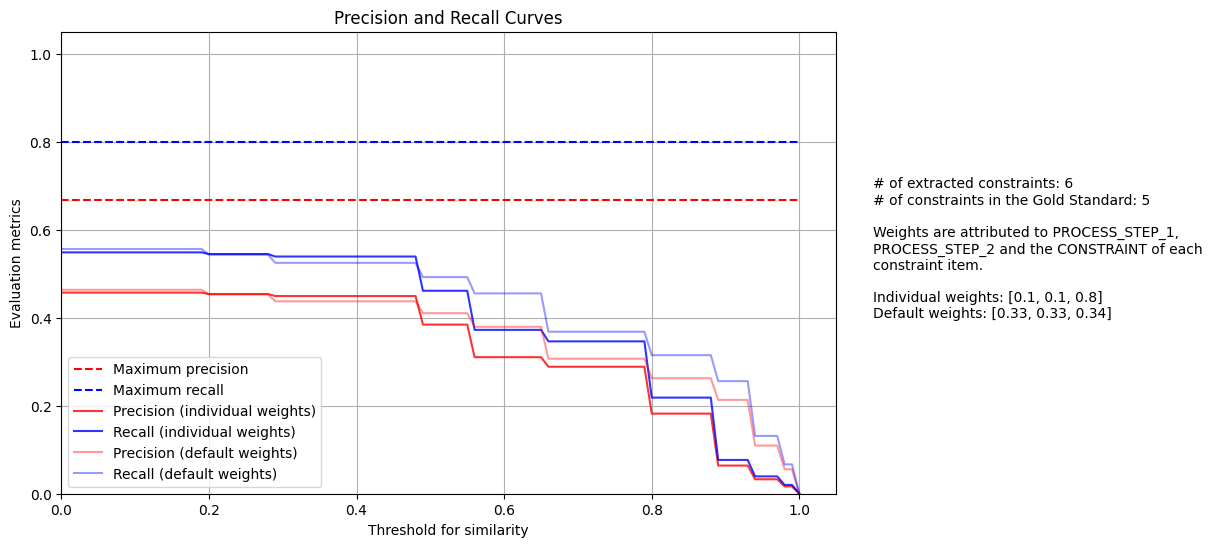

In [34]:
evlt_prec_rec(constraints_dummy_cdm, constraints_gs_cdm, matches_step_1, matches_step_2, matches_constraints, individual_weights=True, weights=[0.1, 0.1, 0.8], hard_cut=True, threshold=0.8, plot_curves=True)

## Next steps


![](../reports/presentations/20231205/5.png)
![](../reports/presentations/20231205/6.png)

Rule based extraction of process steps?

A: 

Relevance of negated constraints?

A: 


Specifics of the calculation of similarity scores?
    
Threshold

A:

"directly follows"

A:

Structure

A:

Calculation of final score?

A:

Literature recommendations? 

A:


![](../reports/presentations/20231205/7.png)